### Predict CO2 emissions in Mauna Lao volcano using Linear Regression

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


In [3]:
co2_df = pd.read_csv("../ts-course-data/co2.csv", index_col = "Date", parse_dates=True)
co2_df.index.freq = "MS"

In [4]:
co2_df.head(5)

,CO2
Date,
1959-01-01,315.42
1959-02-01,316.31
1959-03-01,316.50
1959-04-01,317.56
1959-05-01,318.13


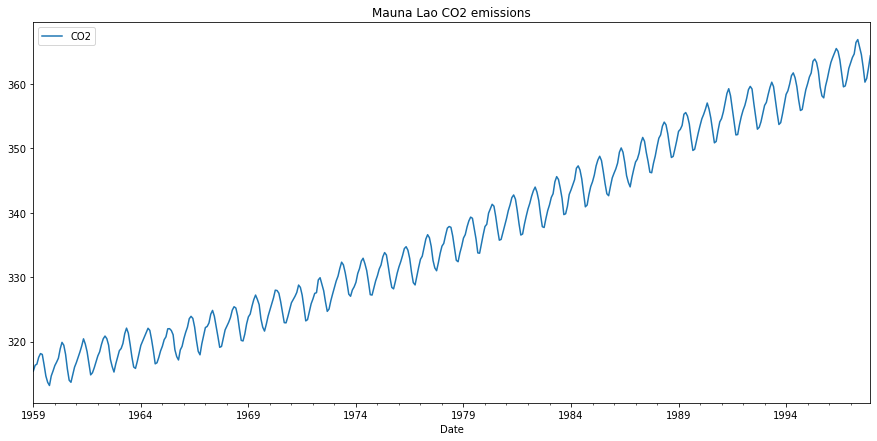

In [5]:
co2_df.plot(figsize = (15, 7), title = "Mauna Lao CO2 emissions")
plt.show()

In [6]:
# fit a basic linear regression model using DeterministicProcess
# split the df into train and test, lets use 10% data as the test dataset

dp = DeterministicProcess (
    index=co2_df.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True
)

X = dp.in_sample()
y = co2_df.loc[:, "CO2"]


In [7]:
X_train, X_test = train_test_split(X, test_size = 0.1, shuffle = False)
y_train, y_test = train_test_split(y, test_size = 0.1, shuffle = False)

In [8]:
X_train.head(4), y_train.head(4)

(            const  trend
 Date                    
 1959-01-01    1.0    1.0
 1959-02-01    1.0    2.0
 1959-03-01    1.0    3.0
 1959-04-01    1.0    4.0,
 Date
 1959-01-01    315.42
 1959-02-01    316.31
 1959-03-01    316.50
 1959-04-01    317.56
 Freq: MS, Name: CO2, dtype: float64)

In [9]:
X_test.head(4), y_test.head(4)

(            const  trend
 Date                    
 1994-02-01    1.0  422.0
 1994-03-01    1.0  423.0
 1994-04-01    1.0  424.0
 1994-05-01    1.0  425.0,
 Date
 1994-02-01    358.89
 1994-03-01    359.95
 1994-04-01    361.25
 1994-05-01    361.67
 Freq: MS, Name: CO2, dtype: float64)

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)

In [11]:
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("rmse is {}".format(rmse))

rmse is 3.345405306433459


In [12]:
y_pred.head(4)

Date
1994-02-01    356.680457
1994-03-01    356.786486
1994-04-01    356.892515
1994-05-01    356.998544
Freq: MS, dtype: float64

In [13]:
y_test.head(4)

Date
1994-02-01    358.89
1994-03-01    359.95
1994-04-01    361.25
1994-05-01    361.67
Freq: MS, Name: CO2, dtype: float64

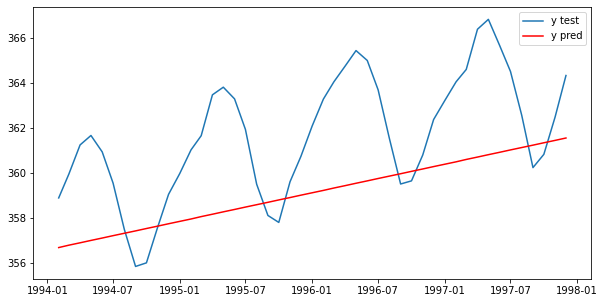

In [14]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y_test, label = "y test")
ax.plot(y_pred, color = "red", label = "y pred")
plt.legend()
plt.show()

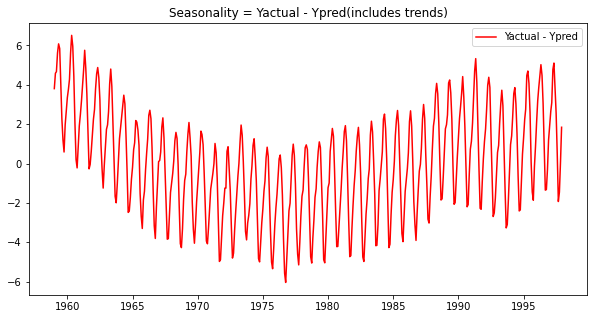

In [15]:
# Lets try to add seasonality.
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y - y_pred, color = "red", label = "Yactual - Ypred")
plt.title("Seasonality = Yactual - Ypred(includes trends)")
plt.legend()
plt.show()

In [16]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=co2_df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 
y = co2_df.loc[:, "CO2"]

X.head(5)

,const,trend,trend_squared,trend_cubed,"s(2,12)","s(10,12)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,1.0,1.0,1.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1959-02-01,1.0,2.0,4.0,8.0,1.0,0.0,0.508671,0.860961,0.875892,0.482508,...,-0.060213,-0.998186,-0.559589,-0.828770,-0.903356,-0.428892,-0.995919,0.090252,-0.811539,0.584298
1959-03-01,1.0,3.0,9.0,27.0,0.0,0.0,0.849817,0.527078,0.895839,-0.444378,...,-0.188227,0.982126,0.735417,0.677615,0.963471,-0.267814,0.280231,-0.959933,-0.668064,-0.744104
1959-04-01,1.0,4.0,16.0,64.0,0.0,0.0,0.999769,0.021516,0.043022,-0.999074,...,0.128748,-0.991677,-0.988678,-0.150055,-0.171293,0.985220,0.981306,0.192452,0.213521,-0.976938
1959-05-01,1.0,5.0,25.0,125.0,0.0,0.0,0.880012,-0.474951,-0.835925,-0.548843,...,-0.171293,0.985220,0.948362,-0.317191,-0.729558,-0.683919,-0.255353,0.966848,0.972118,-0.234491


In [17]:
X_train, X_test = train_test_split(X, test_size = 0.1, shuffle = False)
y_train, y_test = train_test_split(y, test_size = 0.1, shuffle = False)

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)

In [19]:
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("rmse is {}".format(rmse))

rmse is 0.45890455944515707


In [20]:
y_pred.head(4)

Date
1994-02-01    359.542453
1994-03-01    360.450459
1994-04-01    361.675430
1994-05-01    362.312366
Freq: MS, dtype: float64

In [21]:
y_test.head(5)

Date
1994-02-01    358.89
1994-03-01    359.95
1994-04-01    361.25
1994-05-01    361.67
1994-06-01    360.94
Freq: MS, Name: CO2, dtype: float64

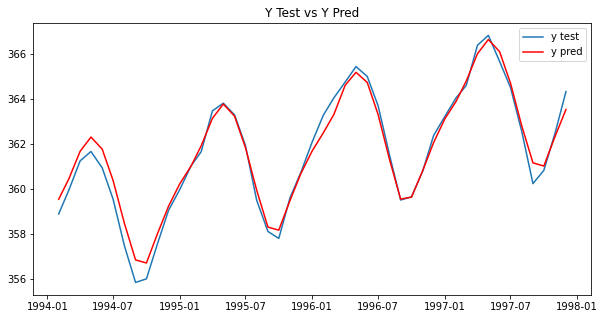

In [22]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y_test, label = "y test")
ax.plot(y_pred, color = "red", label = "y pred")
plt.title("Y Test vs Y Pred")
plt.legend()
plt.show()

In [23]:
X.head(4)

,const,trend,trend_squared,trend_cubed,"s(2,12)","s(10,12)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,1.0,1.0,1.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1959-02-01,1.0,2.0,4.0,8.0,1.0,0.0,0.508671,0.860961,0.875892,0.482508,...,-0.060213,-0.998186,-0.559589,-0.828770,-0.903356,-0.428892,-0.995919,0.090252,-0.811539,0.584298
1959-03-01,1.0,3.0,9.0,27.0,0.0,0.0,0.849817,0.527078,0.895839,-0.444378,...,-0.188227,0.982126,0.735417,0.677615,0.963471,-0.267814,0.280231,-0.959933,-0.668064,-0.744104
1959-04-01,1.0,4.0,16.0,64.0,0.0,0.0,0.999769,0.021516,0.043022,-0.999074,...,0.128748,-0.991677,-0.988678,-0.150055,-0.171293,0.985220,0.981306,0.192452,0.213521,-0.976938


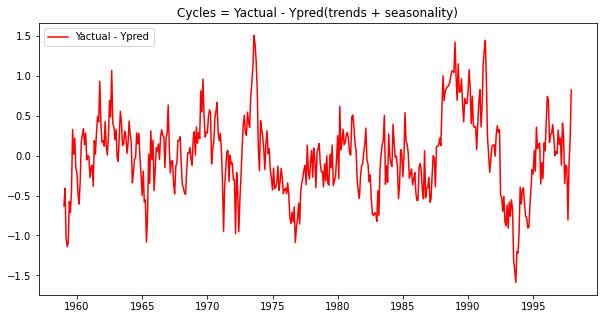

In [24]:
# Lets try to add cycles.
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y - y_pred, color = "red", label = "Yactual - Ypred")
plt.title("Cycles = Yactual - Ypred(trends + seasonality)")
plt.legend()
plt.show()

In [25]:
# lets add a lag of 1

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=co2_df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 
y = co2_df.loc[:, "CO2"]

X["lag_1"] = y.shift(1)
X = X.iloc[1: , :]
y = y[1:]
X_train, X_test = train_test_split(X, test_size = 0.1, shuffle = False)
y_train, y_test = train_test_split(y, test_size = 0.1, shuffle = False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_test), index=X_test.index)

rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("rmse is {}".format(rmse))

rmse is 0.31500363018167443


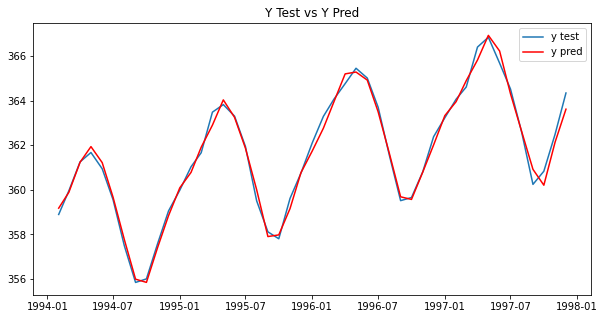

In [26]:
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y_test, label = "y test")
ax.plot(y_pred, color = "red", label = "y pred")
plt.title("Y Test vs Y Pred")
plt.legend()
plt.show()

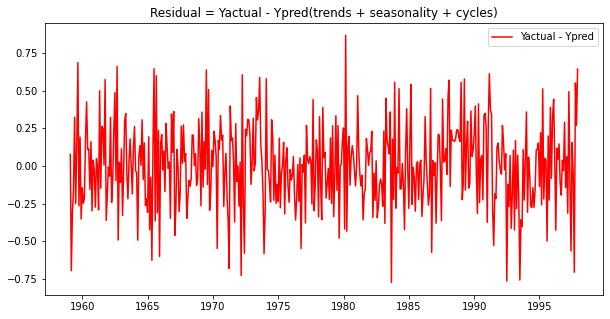

In [27]:
# get the residual
# Lets try to add cycles.
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y - y_pred, color = "red", label = "Yactual - Ypred")
plt.title("Residual = Yactual - Ypred(trends + seasonality + cycles)")
plt.legend()
plt.show()

In [30]:
# Train XGBoost on the residuals
from sklearn.ensemble import GradientBoostingRegressor
y_residual = y - y_pred

X_train, X_test = train_test_split(X, test_size = 0.1, shuffle = False)
y_train, y_test = train_test_split(y_residual, test_size = 0.1, shuffle = False)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred_residual = pd.Series(model.predict(X_test), index=X_test.index)

rmse = np.sqrt(mean_squared_error(y_pred_residual, y_test))
print("rmse is {}".format(rmse))

rmse is 0.3519271303659384


In [36]:
model = GradientBoostingRegressor()
model.fit(X, y_residual)

y_pred_residual = pd.Series(model.predict(X), index=X.index)

In [37]:
final_y = y_pred + y_pred_residual

In [38]:
print(y_pred.head(4), y_pred_residual.head(4), final_y.head(4))

Date
1959-02-01    316.234072
1959-03-01    317.195164
1959-04-01    317.865942
1959-05-01    318.291555
Freq: MS, dtype: float64 Date
1959-02-01   -0.006789
1959-03-01   -0.602503
1959-04-01   -0.258326
1959-05-01   -0.074929
Freq: MS, dtype: float64 Date
1959-02-01    316.227284
1959-03-01    316.592661
1959-04-01    317.607615
1959-05-01    318.216625
Freq: MS, dtype: float64


In [43]:
rmse = np.sqrt(mean_squared_error(final_y, y))
print("rmse is {}".format(rmse))

rmse is 0.19632428726584675


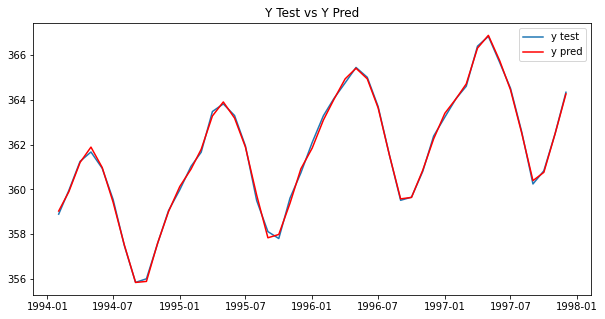

In [45]:
# Perfecto!
final_y_train, final_y_test = train_test_split(final_y, test_size = 0.1, shuffle = False)

plt.figure(figsize = (10, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(y_test, label = "y test")
ax.plot(final_y_test, color = "red", label = "y pred")
plt.title("Y Test vs Y Pred")
plt.legend()
plt.show()
